In [3]:
# A, B, C from HW4 - correct
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags

m = 64    # N value in x and y directions - 8 points in each direction
n = m * m  # total size of matrix - 8 x 8 points (total of 64)

x_start = -10 # left
x_end = 10 # right

delta = (x_end - x_start) / m # Calculate delta

print("Delta (spacing between points):", delta)

e0 = np.zeros((n, 1))  # vector of zeros (of length n = 25)
e1 = np.ones((n, 1))   # vector of ones (of length n = 25)
e2 = np.copy(e1)    # copy the one vector (will be modified next)
e4 = np.copy(e0)    # copy the zero vector (will be modified next)

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwirte every m^th value with one
    
# Shift to correct positions
e3 = np.zeros_like(e2) # shifts each by one and rolls the last position to the first position
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4) # shifts each by one and rolls the last position to the first position
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten() / (delta**2), e1.flatten() / (delta**2), e5.flatten() / (delta**2), # Sets Diagonal elements for A
             e2.flatten() / (delta**2), (-4 * e1.flatten()) / (delta**2), e3.flatten() / (delta**2), 
             e4.flatten() / (delta**2),e1.flatten() / (delta**2), e1.flatten() / (delta**2)]

offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)] # offsets of the diagonals from the main diagonal (A)

matA = spdiags(diagonals, offsets, n, n).toarray() # construct the sparce matrix (A)
matA[0,0] = 2 / (delta**2)
A = matA

# Print the full first row of Matrix A
np.set_printoptions(threshold=np.inf)  # Set threshold to infinity to avoid truncation
print("Full first row of Matrix A:")
print(matA[0])
np.set_printoptions(threshold=1000)  # Reset to default threshold after printing

# Set Diagonals for B
diagonals = [((0.5) * e1.flatten()) / delta, ((-0.5) * e1.flatten()) / delta, ((0.5) * e1.flatten()) / delta, ((-0.5) * e1.flatten()) / delta]

offsets = [-(n-m), -m, m, (n-m)] # offsets of the diagonals from the main diagonal for B

matB = spdiags(diagonals, offsets, n, n).toarray() # construct the sparce matrix for B
B = matB

# Print the full first row of Matrix B
np.set_printoptions(threshold=np.inf)  # Set threshold to infinity to avoid truncation
print("Full first row of Matrix B:")
print(matB[0])
np.set_printoptions(threshold=1000)  # Reset to default threshold after printing

# Diagonal for C
diagonals = [((0.5) * e5.flatten()) / delta, ((-0.5) * e2.flatten()) / delta, ((0.5) * e3.flatten()) / delta, ((-0.5) * e4.flatten()) / delta]
offsets = [-m + 1, -1, 1, m - 1] # Offsets for C

matC = spdiags(diagonals, offsets, n, n).toarray() # construct the sparce matrix (C)
C = matC
# Print the full first row of Matrix C
np.set_printoptions(threshold=np.inf)  # Set threshold to infinity to avoid truncation
print("Full first row of Matrix C:")
print(matC[0])
np.set_printoptions(threshold=1000)  # Reset to default threshold after printing

Delta (spacing between points): 0.3125
Full first row of Matrix A:
[20.48 10.24  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   10.24 10.24  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.

In [4]:
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
import numpy as np
import time

# Define parameters
tspan = np.arange(0, 4+0.5, 0.5) # time points
nu = 0.001 # viscosity
Lx, Ly = 20, 20 # domain limits
nx, ny = 64, 64 # number of grid points
N = nx * ny # total number of points

# Define spatial domain
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

# define initial condition
w = (np.exp(-X**2 - (Y**2)/20)).flatten()

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6 # avoid division by zero
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6 # avoid division by zero
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# define RHS function for the ODE
def spc_rhs(t, w, nx, ny, K, nu):
    wm = w.reshape((nx, ny)) # reshape into matrix form
    wft = fft2(wm) # fourier transform of w
    psit = -wft / K # poisson equation for streamfunctin in Fourier space
    psi_m = np.real(ifft2(psit)) # transform back to real space (matrix form)
    psi_A1 = psi_m.flatten() # flattened
    wt = nu * np.dot(matA, w) - (np.dot(matB, psi_A1) * np.dot(matC, w)) + (np.dot(matC, psi_A1) * np.dot(matB, w))
    return wt

start_time = time.time() # start time clock
A1_sol = solve_ivp( # solve IVP
    spc_rhs, #rhs devined above
    (tspan[0], tspan[-1]), # tspan from above
    w, # w function from above
    t_eval=tspan, # tspan from above
    method = 'RK45', # runga kutta 45 per homework problem
    args = (nx, ny, K, nu)) # variables included
end_time = time.time() # end time clock

A1 = A1_sol.y

print("Shape of A1:", A1.shape)  # shape should be (4096, 9)
print(f"Elapsed time: {end_time - start_time:.2f} seconds")
print(f"A1[0, 0]: {A1[0, 0]}, A1[-1, -1]: {A1[-1, -1]}")

Shape of A1: (4096, 9)
Elapsed time: 0.86 seconds
A1[0, 0]: 2.506567475899953e-46, A1[-1, -1]: 2.0736155523432726e-38


In [5]:
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp
from numpy.linalg import solve
from scipy.linalg import lu, solve_triangular
import numpy as np
import time

# A\b for A2
def A2_rhs(t, w, matA, matB, matC, nu):
    psi_A2 = np.linalg.solve(matA,w)
    A2_rhs = nu * np.dot(matA, w) - (np.dot(matB, psi_A2) * np.dot(matC, w)) + (np.dot(matC, psi_A2) * np.dot(matB, w))
    return A2_rhs

# Solve the ODE
start_time = time.time() # Record the start time
A2_solution = solve_ivp(
    A2_rhs,
    [tspan[0], tspan[-1]],
    w,
    method='RK45',
    t_eval=tspan,
    args=(matA, matB, matC, nu)
)
end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time A2: {elapsed_time:.2f} seconds")

A2 = A2_solution.y
print(f"A2[0, 0]: {A2[0, 0]}, A2[-1, -1]: {A2[-1, -1]}")
print("Shape of A2:", A2.shape)  # A2 contains solutions from A\b

# LU for A3
P, L, U = lu(matA) # Precompute LU decomposition of matrix A
def A3_rhs(t, w, P, L, U, matA, matB, matC):
    Pw = np.dot(P, w) # Solve for psi using LU factors from homework
    y = solve_triangular(L, Pw, lower=True)
    psi_A3 = solve_triangular(U, y)
    # Compute RHS
    A3_rhs = nu * np.dot(matA, w) - (np.dot(matB, psi_A3) * np.dot(matC, w)) + (np.dot(matC, psi_A3) * np.dot(matB, w))
    return A3_rhs
    
# Solve the ODE using solve_ivp
start_time = time.time() # Record the start time
A3_solution = solve_ivp(
    A3_rhs,
    [tspan[0], tspan[-1]],
    w,
    method='RK45',
    t_eval=tspan,
    args=(P, L, U, matA, matB, matC)  # Pass LU factors as arguments
)
end_time = time.time() # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time A3: {elapsed_time:.2f} seconds")

A3 = A3_solution.y
print(f"A3[0, 0]: {A3[0, 0]}, A3[-1, -1]: {A3[-1, -1]}")

print("Shape of A3:", A3.shape)  # A3 contains solutions from LU decomposition

Elapsed time A2: 13.83 seconds
A2[0, 0]: 2.506567475899953e-46, A2[-1, -1]: 3.127612542993891e-20
Shape of A2: (4096, 9)
Elapsed time A3: 1.85 seconds
A3[0, 0]: 2.506567475899953e-46, A3[-1, -1]: 3.1276125429859386e-20
Shape of A3: (4096, 9)


C:\Users\bbose


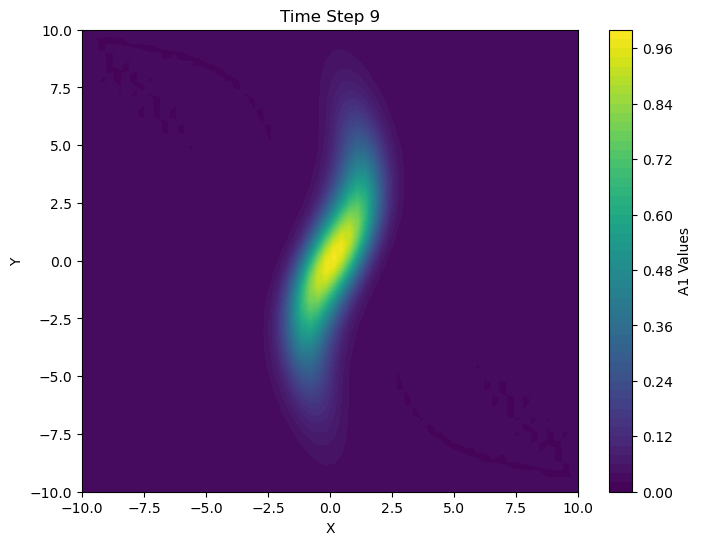

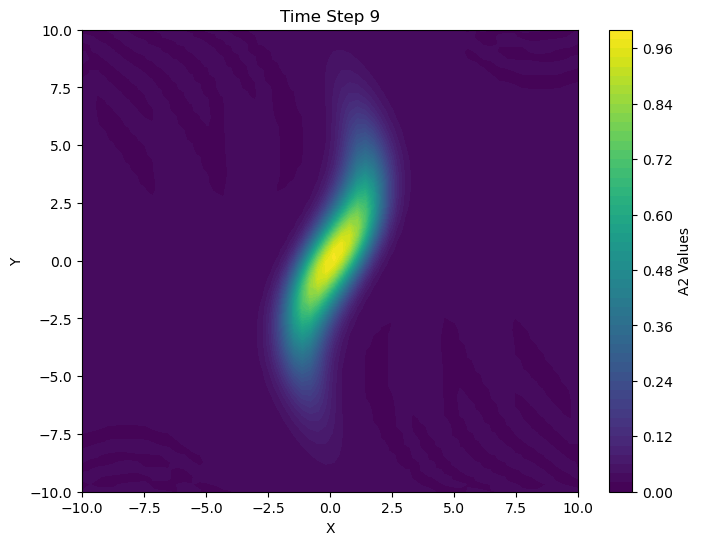

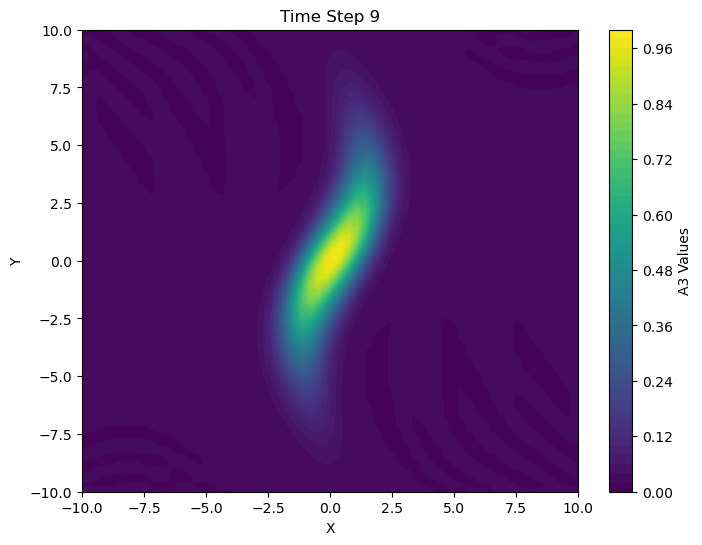

In [24]:
# Videos
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft2, ifft2
from IPython.display import HTML
import os

# Spatial domain
Lx, Ly = 20, 20  # Domain limits
nx, ny = 64, 64  # Number of grid points
x = np.linspace(-Lx / 2, Lx / 2, nx)
y = np.linspace(-Ly / 2, Ly / 2, ny)
X, Y = np.meshgrid(x, y)

# Reshape A1 for visualization
n_time_steps = A1.shape[1]  # Number of time steps
A1_reshaped = [A1[:, i].reshape((nx, ny)) for i in range(n_time_steps)]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, A1_reshaped[0], levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('A1 Values')
ax.set_title("Time Evolution of A1")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Animation update function
def update(frame):
    ax.clear()
    contour = ax.contourf(X, Y, A1_reshaped[frame], levels=50, cmap='viridis')
    ax.set_title(f"Time Step {frame + 1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return contour

# Create the animation
anim = FuncAnimation(fig, update, frames=n_time_steps, blit=False)

# Display the animation inline
HTML(anim.to_jshtml())

# Save the animation as a GIF
anim.save('A1_evolution.gif', fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer
print(os.getcwd())  # This will show your current working directory
plt.show()

# Reshape A2 for visualization
n_time_steps = A2.shape[1]  # Number of time steps
A2_reshaped = [A2[:, i].reshape((nx, ny)) for i in range(n_time_steps)]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, A2_reshaped[0], levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('A2 Values')
ax.set_title("Time Evolution of A2")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Animation update function
def update(frame):
    ax.clear()
    contour = ax.contourf(X, Y, A2_reshaped[frame], levels=50, cmap='viridis')
    ax.set_title(f"Time Step {frame + 1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return contour

# Create the animation
anim = FuncAnimation(fig, update, frames=n_time_steps, blit=False)

# Display the animation inline
HTML(anim.to_jshtml())

# Save the animation as a GIF
anim.save('A2_evolution.gif', fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer
plt.show()

# Reshape A3 for visualization
n_time_steps = A3.shape[1]  # Number of time steps
A3_reshaped = [A3[:, i].reshape((nx, ny)) for i in range(n_time_steps)]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, A3_reshaped[0], levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('A3 Values')
ax.set_title("Time Evolution of A3")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Animation update function
def update(frame):
    ax.clear()
    contour = ax.contourf(X, Y, A3_reshaped[frame], levels=50, cmap='viridis')
    ax.set_title(f"Time Step {frame + 1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return contour

# Create the animation
anim = FuncAnimation(fig, update, frames=n_time_steps, blit=False)

# Display the animation inline
HTML(anim.to_jshtml())

# Save the animation as a GIF
anim.save('A3_evolution.gif', fps=10, dpi=150, writer='pillow')  # Use 'pillow' writer
plt.show()